In [6]:
import time
import os 

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'
output_dir = os.getcwd() + '/Output/'

In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import numpy as np

cuda


In [9]:
content_images = ["Content/04.png", "Content/01.png", "Content/05.png", "Content/10.png", "Content/12.png", "Content/19.png"]
style_images = ["Style/01.png", "Style/02.png", "Style/03.png", "Style/10.png", "Style/04.png", "Style/09.png"]
n_iterations = 500

In [10]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [11]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [12]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [13]:
#get network
vgg = VGG(pool="max")
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [14]:
def run_transfer(style_name, content_name, init_method="content", max_iter=500, show_iter=50, output_dir=output_dir):
    #load images, ordered as [style_image, content_image]
    img_dirs = [image_dir, image_dir]
    img_names = [style_name, content_name]
    imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image = imgs_torch

    if init_method == "random":
        opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True)
    elif init_method == "content":
        opt_img = Variable(content_image.data.clone(), requires_grad=True)
    elif init_method == "style":
        resize_to_content = transforms.Resize((imgs[1].height, imgs[1].width))
        style_image_resized = resize_to_content(imgs[0])
        if torch.cuda.is_available():
            opt_img = Variable(prep(style_image_resized).unsqueeze(0).cuda(), requires_grad=True)
        else:
            opt_img = Variable(prep(style_image_resized).unsqueeze(0), requires_grad=True)

    optimizer = optim.LBFGS([opt_img])
    n_iter=[0]

    #define layers, loss functions, weights and compute optimization targets
    style_layers = ['r11','r21','r31','r41','r51'] 
    content_layers = ['r42']
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
        
    #these are good weights settings:
    style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    content_weights = [1e0]
    weights = style_weights + content_weights

    #compute optimization targets
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
    content_targets = [A.detach() for A in vgg(content_image, content_layers)]
    targets = style_targets + content_targets

    # set up timer
    losses = []

    #run style transfer
    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = torch.stack(layer_losses, dim=0).sum(dim=0)
            loss.backward()
            n_iter[0]+=1
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
                losses.append(loss.item())
            return loss
        
        optimizer.step(closure)
        
    #display result
    out_img = postp(opt_img.data[0].cpu().squeeze())
    #plt.imshow(out_img)
    #plt.gcf().set_size_inches(10,10)
    out_img.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")
    return losses

In [15]:
content_losses = []
for i in range(len(style_images)):
    content_losses.append(run_transfer(style_images[i], content_images[i], "content", 5000, 25, output_dir+'content_max_5000/'))

Iteration: 25, loss: 5127334.000000
Iteration: 50, loss: 2210153.750000
Iteration: 75, loss: 1204250.375000
Iteration: 100, loss: 818322.750000
Iteration: 125, loss: 650713.062500
Iteration: 150, loss: 525892.750000
Iteration: 175, loss: 457931.843750
Iteration: 200, loss: 413963.656250
Iteration: 225, loss: 380403.031250
Iteration: 250, loss: 353977.437500
Iteration: 275, loss: 333731.781250
Iteration: 300, loss: 317707.406250
Iteration: 325, loss: 304545.812500
Iteration: 350, loss: 294087.218750
Iteration: 375, loss: 285668.687500
Iteration: 400, loss: 279058.562500
Iteration: 425, loss: 273685.156250
Iteration: 450, loss: 268993.718750
Iteration: 475, loss: 265076.218750
Iteration: 500, loss: 261685.296875
Iteration: 525, loss: 258559.078125
Iteration: 550, loss: 255859.546875
Iteration: 575, loss: 253474.562500
Iteration: 600, loss: 251287.687500
Iteration: 625, loss: 249360.375000
Iteration: 650, loss: 247606.734375
Iteration: 675, loss: 246090.656250
Iteration: 700, loss: 244653

In [16]:
random_losses = []
for i in range(len(style_images)):
    random_losses.append(run_transfer(style_images[i], content_images[i], "random", 5000, 25, output_dir+'random_max_5000/'))

Iteration: 25, loss: 10486283.000000
Iteration: 50, loss: 2846600.500000
Iteration: 75, loss: 1510965.875000
Iteration: 100, loss: 1043441.375000
Iteration: 125, loss: 807932.250000
Iteration: 150, loss: 685234.937500
Iteration: 175, loss: 598428.812500
Iteration: 200, loss: 540552.812500
Iteration: 225, loss: 500665.875000
Iteration: 250, loss: 469155.093750
Iteration: 275, loss: 444112.468750
Iteration: 300, loss: 423010.312500
Iteration: 325, loss: 406084.531250
Iteration: 350, loss: 391017.468750
Iteration: 375, loss: 378950.562500
Iteration: 400, loss: 367225.531250
Iteration: 425, loss: 356977.718750
Iteration: 450, loss: 347886.781250
Iteration: 475, loss: 339831.687500
Iteration: 500, loss: 332414.625000
Iteration: 525, loss: 325774.500000
Iteration: 550, loss: 319842.281250
Iteration: 575, loss: 314537.281250
Iteration: 600, loss: 309462.906250
Iteration: 625, loss: 305189.937500
Iteration: 650, loss: 300903.062500
Iteration: 675, loss: 296961.750000
Iteration: 700, loss: 2932

In [17]:
style_losses = []
for i in range(len(style_images)):
    style_losses.append(run_transfer(style_images[i], content_images[i], "style", 5000, 25, output_dir+'style_max_5000/'))

Iteration: 25, loss: 702455.000000
Iteration: 50, loss: 469075.093750
Iteration: 75, loss: 409775.312500
Iteration: 100, loss: 379489.750000
Iteration: 125, loss: 358563.656250
Iteration: 150, loss: 343518.406250
Iteration: 175, loss: 331544.906250
Iteration: 200, loss: 321751.500000
Iteration: 225, loss: 313828.843750
Iteration: 250, loss: 306815.093750
Iteration: 275, loss: 300769.062500
Iteration: 300, loss: 295566.843750
Iteration: 325, loss: 291261.062500
Iteration: 350, loss: 287562.343750
Iteration: 375, loss: 284057.187500
Iteration: 400, loss: 281197.125000
Iteration: 425, loss: 278359.531250
Iteration: 450, loss: 275689.406250
Iteration: 475, loss: 273209.375000
Iteration: 500, loss: 271046.281250
Iteration: 525, loss: 268993.687500
Iteration: 550, loss: 267105.437500
Iteration: 575, loss: 265475.875000
Iteration: 600, loss: 263934.656250
Iteration: 625, loss: 262401.250000
Iteration: 650, loss: 260963.984375
Iteration: 675, loss: 259697.109375
Iteration: 700, loss: 258484.15

In [18]:
content_losses_np = np.array(content_losses)
random_losses_np = np.array(random_losses)
style_losses_np = np.array(style_losses)

np.savetxt(output_dir+"content_max_losses.csv", content_losses_np, delimiter=",")
np.savetxt(output_dir+"random_max_losses.csv", random_losses_np, delimiter=",")
np.savetxt(output_dir+"style_max_losses.csv", style_losses_np, delimiter=",")

In [19]:
content_losses_np = np.genfromtxt(output_dir+"content_max_losses.csv", delimiter=",")
random_losses_np = np.genfromtxt(output_dir+"random_max_losses.csv", delimiter=",")
style_losses_np = np.genfromtxt(output_dir+"style_max_losses.csv", delimiter=",")

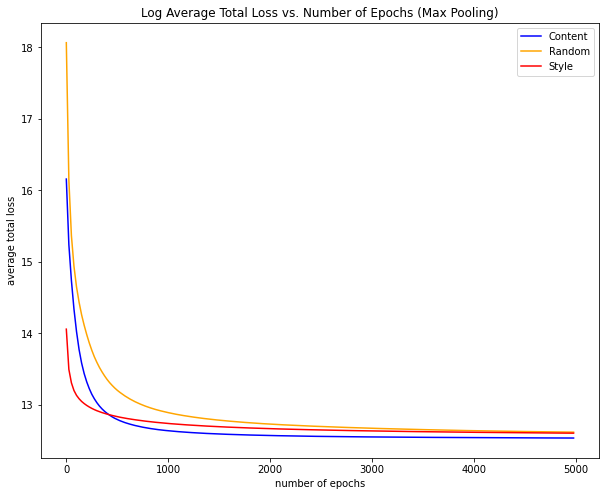

In [21]:
plt.figure(figsize=[10,8])
plt.plot(range(0, 5000, 25), np.log(content_losses_np.mean(axis=0)), color = "blue")
plt.plot(range(0, 5000, 25), np.log(random_losses_np.mean(axis=0)), color = "orange")
plt.plot(range(0, 5000, 25), np.log(style_losses_np.mean(axis=0)), color = "red")
plt.legend(labels = ["Content", "Random", "Style"], loc = "upper right")
plt.xlabel("number of epochs")
plt.ylabel("average total loss")
plt.title("Log Average Total Loss vs. Number of Epochs (Max Pooling)")
plt.draw()
plt.ioff()
plt.show()

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 2000, 25, output_dir+'content_max_2000/')

Iteration: 25, loss: 5133713.000000
Iteration: 50, loss: 2191064.750000
Iteration: 75, loss: 1137770.000000
Iteration: 100, loss: 786459.187500
Iteration: 125, loss: 626609.625000
Iteration: 150, loss: 524691.250000
Iteration: 175, loss: 458600.062500
Iteration: 200, loss: 409446.687500
Iteration: 225, loss: 376876.281250
Iteration: 250, loss: 351227.781250
Iteration: 275, loss: 330924.312500
Iteration: 300, loss: 314835.562500
Iteration: 325, loss: 302623.312500
Iteration: 350, loss: 292596.750000
Iteration: 375, loss: 284417.562500
Iteration: 400, loss: 278112.718750
Iteration: 425, loss: 272721.812500
Iteration: 450, loss: 268322.312500
Iteration: 475, loss: 264682.656250
Iteration: 500, loss: 261158.078125
Iteration: 525, loss: 258276.109375
Iteration: 550, loss: 255635.906250
Iteration: 575, loss: 253309.562500
Iteration: 600, loss: 251171.375000
Iteration: 625, loss: 249309.484375
Iteration: 650, loss: 247690.796875
Iteration: 675, loss: 246109.828125
Iteration: 700, loss: 244662

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 2000, 25, output_dir+'random_max_2000/')

Iteration: 25, loss: 10580157.000000
Iteration: 50, loss: 3026037.000000
Iteration: 75, loss: 1532063.500000
Iteration: 100, loss: 1036080.562500
Iteration: 125, loss: 801087.250000
Iteration: 150, loss: 678320.562500
Iteration: 175, loss: 592750.750000
Iteration: 200, loss: 537381.687500
Iteration: 225, loss: 497968.906250
Iteration: 250, loss: 466707.031250
Iteration: 275, loss: 441753.125000
Iteration: 300, loss: 421256.625000
Iteration: 325, loss: 403873.468750
Iteration: 350, loss: 389597.125000
Iteration: 375, loss: 377012.718750
Iteration: 400, loss: 365779.437500
Iteration: 425, loss: 355658.843750
Iteration: 450, loss: 346564.281250
Iteration: 475, loss: 338766.062500
Iteration: 500, loss: 331476.500000
Iteration: 525, loss: 324934.250000
Iteration: 550, loss: 318771.687500
Iteration: 575, loss: 313341.187500
Iteration: 600, loss: 308272.031250
Iteration: 625, loss: 303659.656250
Iteration: 650, loss: 299442.937500
Iteration: 675, loss: 295699.625000
Iteration: 700, loss: 2922

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 2000, 25, output_dir+'style_max_2000/')

Iteration: 25, loss: 703441.437500
Iteration: 50, loss: 470482.625000
Iteration: 75, loss: 411298.750000
Iteration: 100, loss: 379371.593750
Iteration: 125, loss: 358262.750000
Iteration: 150, loss: 342941.625000
Iteration: 175, loss: 331120.656250
Iteration: 200, loss: 321678.687500
Iteration: 225, loss: 313266.750000
Iteration: 250, loss: 306771.812500
Iteration: 275, loss: 300824.812500
Iteration: 300, loss: 295892.656250
Iteration: 325, loss: 291571.687500
Iteration: 350, loss: 287650.000000
Iteration: 375, loss: 284105.062500
Iteration: 400, loss: 280975.218750
Iteration: 425, loss: 278043.781250
Iteration: 450, loss: 275441.343750
Iteration: 475, loss: 273025.593750
Iteration: 500, loss: 270783.312500
Iteration: 525, loss: 268656.187500
Iteration: 550, loss: 266745.468750
Iteration: 575, loss: 265037.812500
Iteration: 600, loss: 263395.125000
Iteration: 625, loss: 261827.609375
Iteration: 650, loss: 260395.875000
Iteration: 675, loss: 259085.093750
Iteration: 700, loss: 257895.18

In [16]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 1000, 25, output_dir+'content_max_1000/')

Iteration: 25, loss: 5146154.000000
Iteration: 50, loss: 2282365.500000
Iteration: 75, loss: 1170959.250000
Iteration: 100, loss: 801498.625000
Iteration: 125, loss: 640999.250000
Iteration: 150, loss: 532080.437500
Iteration: 175, loss: 467222.593750
Iteration: 200, loss: 418604.562500
Iteration: 225, loss: 382422.000000
Iteration: 250, loss: 355251.250000
Iteration: 275, loss: 333255.312500
Iteration: 300, loss: 318095.406250
Iteration: 325, loss: 305607.468750
Iteration: 350, loss: 294931.562500
Iteration: 375, loss: 286599.093750
Iteration: 400, loss: 279814.906250
Iteration: 425, loss: 274232.593750
Iteration: 450, loss: 269569.406250
Iteration: 475, loss: 265467.125000
Iteration: 500, loss: 261876.671875
Iteration: 525, loss: 259110.046875
Iteration: 550, loss: 256398.171875
Iteration: 575, loss: 253881.015625
Iteration: 600, loss: 251727.265625
Iteration: 625, loss: 249885.562500
Iteration: 650, loss: 248141.437500
Iteration: 675, loss: 246626.437500
Iteration: 700, loss: 245223

In [17]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 1000, 25, output_dir+'random_max_1000/')

Iteration: 25, loss: 10131554.000000
Iteration: 50, loss: 2678002.000000
Iteration: 75, loss: 1500881.250000
Iteration: 100, loss: 1013247.250000
Iteration: 125, loss: 788849.062500
Iteration: 150, loss: 671130.562500
Iteration: 175, loss: 592678.750000
Iteration: 200, loss: 534708.062500
Iteration: 225, loss: 496823.531250
Iteration: 250, loss: 466063.781250
Iteration: 275, loss: 441006.468750
Iteration: 300, loss: 421002.250000
Iteration: 325, loss: 404888.625000
Iteration: 350, loss: 389762.406250
Iteration: 375, loss: 377068.968750
Iteration: 400, loss: 366042.875000
Iteration: 425, loss: 355803.593750
Iteration: 450, loss: 346746.312500
Iteration: 475, loss: 338776.156250
Iteration: 500, loss: 331278.718750
Iteration: 525, loss: 324448.312500
Iteration: 550, loss: 318383.343750
Iteration: 575, loss: 313026.812500
Iteration: 600, loss: 308078.906250
Iteration: 625, loss: 303305.812500
Iteration: 650, loss: 298956.187500
Iteration: 675, loss: 294919.312500
Iteration: 700, loss: 2912

In [18]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 1000, 25, output_dir+'style_max_1000/')

Iteration: 25, loss: 701564.500000
Iteration: 50, loss: 471712.250000
Iteration: 75, loss: 410368.593750
Iteration: 100, loss: 379672.937500
Iteration: 125, loss: 358543.343750
Iteration: 150, loss: 343154.625000
Iteration: 175, loss: 330984.125000
Iteration: 200, loss: 321053.343750
Iteration: 225, loss: 313224.625000
Iteration: 250, loss: 306429.187500
Iteration: 275, loss: 300547.156250
Iteration: 300, loss: 295761.937500
Iteration: 325, loss: 291526.812500
Iteration: 350, loss: 287549.531250
Iteration: 375, loss: 284056.468750
Iteration: 400, loss: 280987.656250
Iteration: 425, loss: 278144.093750
Iteration: 450, loss: 275485.500000
Iteration: 475, loss: 273030.375000
Iteration: 500, loss: 270956.687500
Iteration: 525, loss: 268882.531250
Iteration: 550, loss: 266967.281250
Iteration: 575, loss: 265237.937500
Iteration: 600, loss: 263637.562500
Iteration: 625, loss: 262103.656250
Iteration: 650, loss: 260630.218750
Iteration: 675, loss: 259298.109375
Iteration: 700, loss: 258011.03

In [19]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 500, 25, output_dir+'content_max_500/')

Iteration: 25, loss: 5091098.500000
Iteration: 50, loss: 2153164.750000
Iteration: 75, loss: 1155976.500000
Iteration: 100, loss: 811592.500000
Iteration: 125, loss: 635150.750000
Iteration: 150, loss: 532106.000000
Iteration: 175, loss: 459781.187500
Iteration: 200, loss: 410490.312500
Iteration: 225, loss: 376840.562500
Iteration: 250, loss: 351696.250000
Iteration: 275, loss: 331125.093750
Iteration: 300, loss: 314608.750000
Iteration: 325, loss: 302379.375000
Iteration: 350, loss: 292460.250000
Iteration: 375, loss: 284660.062500
Iteration: 400, loss: 277998.687500
Iteration: 425, loss: 272761.250000
Iteration: 450, loss: 268501.937500
Iteration: 475, loss: 264718.187500
Iteration: 500, loss: 261393.390625
Iteration: 25, loss: 5120862.500000
Iteration: 50, loss: 2641978.000000
Iteration: 75, loss: 1738827.125000
Iteration: 100, loss: 1170056.375000
Iteration: 125, loss: 831802.500000
Iteration: 150, loss: 615108.750000
Iteration: 175, loss: 473728.812500
Iteration: 200, loss: 37787

In [20]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 500, 25, output_dir+'random_max_500/')

Iteration: 25, loss: 10536864.000000
Iteration: 50, loss: 2887640.000000
Iteration: 75, loss: 1561258.750000
Iteration: 100, loss: 1038391.375000
Iteration: 125, loss: 803683.625000
Iteration: 150, loss: 670243.375000
Iteration: 175, loss: 589323.125000
Iteration: 200, loss: 533084.312500
Iteration: 225, loss: 492078.000000
Iteration: 250, loss: 462309.687500
Iteration: 275, loss: 436911.312500
Iteration: 300, loss: 418018.750000
Iteration: 325, loss: 401803.375000
Iteration: 350, loss: 387497.218750
Iteration: 375, loss: 374886.156250
Iteration: 400, loss: 364519.375000
Iteration: 425, loss: 354666.531250
Iteration: 450, loss: 345647.437500
Iteration: 475, loss: 338247.812500
Iteration: 500, loss: 331622.812500
Iteration: 25, loss: 7394907.500000
Iteration: 50, loss: 2303478.250000
Iteration: 75, loss: 1341082.250000
Iteration: 100, loss: 937297.750000
Iteration: 125, loss: 727957.875000
Iteration: 150, loss: 600754.375000
Iteration: 175, loss: 503188.562500
Iteration: 200, loss: 4349

In [21]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 500, 25, output_dir+'style_max_500/')

Iteration: 25, loss: 702499.687500
Iteration: 50, loss: 473849.281250
Iteration: 75, loss: 409961.593750
Iteration: 100, loss: 377760.062500
Iteration: 125, loss: 357124.125000
Iteration: 150, loss: 342206.343750
Iteration: 175, loss: 330645.406250
Iteration: 200, loss: 321063.687500
Iteration: 225, loss: 312703.625000
Iteration: 250, loss: 306059.687500
Iteration: 275, loss: 300106.093750
Iteration: 300, loss: 295100.562500
Iteration: 325, loss: 290944.781250
Iteration: 350, loss: 287171.937500
Iteration: 375, loss: 283679.875000
Iteration: 400, loss: 280536.500000
Iteration: 425, loss: 277709.062500
Iteration: 450, loss: 275221.312500
Iteration: 475, loss: 272899.218750
Iteration: 500, loss: 270664.187500
Iteration: 25, loss: 504315.875000
Iteration: 50, loss: 373784.812500
Iteration: 75, loss: 323607.437500
Iteration: 100, loss: 294990.125000
Iteration: 125, loss: 275122.562500
Iteration: 150, loss: 260057.015625
Iteration: 175, loss: 248023.421875
Iteration: 200, loss: 238850.65625

In [22]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 200, 25, output_dir+'content_max_200/')

Iteration: 25, loss: 5143563.000000
Iteration: 50, loss: 2198793.250000
Iteration: 75, loss: 1182373.000000
Iteration: 100, loss: 809456.125000
Iteration: 125, loss: 641733.312500
Iteration: 150, loss: 532434.000000
Iteration: 175, loss: 463777.125000
Iteration: 200, loss: 415517.000000
Iteration: 25, loss: 5121996.000000
Iteration: 50, loss: 2619085.500000
Iteration: 75, loss: 1743929.125000
Iteration: 100, loss: 1185993.375000
Iteration: 125, loss: 830016.687500
Iteration: 150, loss: 613204.500000
Iteration: 175, loss: 470243.031250
Iteration: 200, loss: 379376.031250
Iteration: 25, loss: 17658918.000000
Iteration: 50, loss: 7105019.000000
Iteration: 75, loss: 4434058.000000
Iteration: 100, loss: 3162647.500000
Iteration: 125, loss: 2482081.000000
Iteration: 150, loss: 2000787.000000
Iteration: 175, loss: 1688461.750000
Iteration: 200, loss: 1449708.875000
Iteration: 25, loss: 10034986.000000
Iteration: 50, loss: 3918653.000000
Iteration: 75, loss: 2387052.750000
Iteration: 100, loss

In [23]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 200, 25, output_dir+'random_max_200/')

Iteration: 25, loss: 10212059.000000
Iteration: 50, loss: 2893102.750000
Iteration: 75, loss: 1557538.250000
Iteration: 100, loss: 1041842.375000
Iteration: 125, loss: 807530.125000
Iteration: 150, loss: 674186.875000
Iteration: 175, loss: 592682.625000
Iteration: 200, loss: 538276.375000
Iteration: 25, loss: 16956642.000000
Iteration: 50, loss: 2925112.750000
Iteration: 75, loss: 1518258.250000
Iteration: 100, loss: 1053215.625000
Iteration: 125, loss: 806758.062500
Iteration: 150, loss: 661936.062500
Iteration: 175, loss: 562541.375000
Iteration: 200, loss: 476111.468750
Iteration: 25, loss: 277711936.000000
Iteration: 50, loss: 31838964.000000
Iteration: 75, loss: 12741678.000000
Iteration: 100, loss: 7503704.000000
Iteration: 125, loss: 5170290.000000
Iteration: 150, loss: 4001757.000000
Iteration: 175, loss: 3240161.000000
Iteration: 200, loss: 2781249.000000
Iteration: 25, loss: 52515300.000000
Iteration: 50, loss: 11394668.000000
Iteration: 75, loss: 6583137.000000
Iteration: 10

In [24]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 200, 25, output_dir+'style_max_200/')

Iteration: 25, loss: 701721.687500
Iteration: 50, loss: 472717.125000
Iteration: 75, loss: 409268.781250
Iteration: 100, loss: 378440.812500
Iteration: 125, loss: 358258.875000
Iteration: 150, loss: 343154.656250
Iteration: 175, loss: 331153.750000
Iteration: 200, loss: 321549.500000
Iteration: 25, loss: 506126.218750
Iteration: 50, loss: 370783.437500
Iteration: 75, loss: 321644.906250
Iteration: 100, loss: 291961.406250
Iteration: 125, loss: 272869.312500
Iteration: 150, loss: 258553.828125
Iteration: 175, loss: 247383.671875
Iteration: 200, loss: 237961.812500
Iteration: 25, loss: 2458601.500000
Iteration: 50, loss: 1368556.750000
Iteration: 75, loss: 1092145.125000
Iteration: 100, loss: 971419.500000
Iteration: 125, loss: 903417.625000
Iteration: 150, loss: 859793.000000
Iteration: 175, loss: 830845.625000
Iteration: 200, loss: 808404.875000
Iteration: 25, loss: 2123459.750000
Iteration: 50, loss: 976211.562500
Iteration: 75, loss: 702705.125000
Iteration: 100, loss: 611995.062500


In [25]:
# test block, will eventually remove it
#temp1 = Image.open(image_dir+style_name)
#img_resize = transforms.Resize((temp.height, temp.width))
#temp_resized = img_resize(temp1)
#plt.imshow(temp_resized)
#temp_resized.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")